In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [5]:
sim_result_path = './0409_run_result_sim/'
sim_ensemble_path = './0409_ensemble_sim_1/'
tabular_result_path = './0410_run_result_tabular/'
tabular_ensemble_path = './0410_ensemble_sim_1/'

# simulation

In [12]:
cols = ['trainer_name', 'sampling_term','sampling_ratio','initial_epoch']
for result in os.listdir(sim_result_path):
    data = pd.read_csv(sim_result_path + result)
    print(result)
    print(data.groupby(cols)[['roc_auc','pr_auc']].agg(['mean']))

result_smallNormal.csv
                                                        roc_auc  pr_auc
                                                           mean    mean
trainer_name sampling_term sampling_ratio initial_epoch                
BaseTrainer  0             0.00           0              0.8277  0.7944
NewTrainer   1             0.01           5              0.8605  0.8249
                                          20             0.8515  0.8299
                           0.10           5              0.8224  0.7831
                                          20             0.8335  0.8008
             5             0.01           5              0.8352  0.8052
                                          20             0.8211  0.7834
                           0.10           5              0.8437  0.8096
                                          20             0.8372  0.8121
result_smallTestNoise_010_01.csv
                                                        roc_auc  pr_auc
        

In [15]:
cols = ['trainer_name', 'sampling_term','sampling_ratio','initial_epoch']
for result in os.listdir(sim_result_path):
    data = pd.read_csv(sim_result_path + result)
    tmp = data.groupby(cols)[['roc_auc','pr_auc']].agg(['mean'])
    break

In [24]:
for roc, pr in zip(tmp['roc_auc'].values, tmp['pr_auc'].values):
    print(roc[0], pr[0])
    break

0.8277 0.7944


In [27]:
viz_df = pd.DataFrame(columns=['AUCROC','AUCPR','data'])
cols = ['trainer_name', 'sampling_term','sampling_ratio','initial_epoch']
for result in os.listdir(sim_result_path):
    data = pd.read_csv(sim_result_path + result)
    data = data.loc[data['trainer_name'] == 'NewTrainer']
    tmp = data.groupby(cols)[['roc_auc','pr_auc']].agg(['mean'])
    for roc, pr in zip(tmp['roc_auc'].values, tmp['pr_auc'].values):
        viz_df = viz_df.append({
            'AUCROC': roc[0],
            'AUCPR': pr[0],
            'data': result
        }, ignore_index=True)

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def _normalize_tabular(df: pd.DataFrame, label_name: str = "label"):
    scaler = StandardScaler()
    X = scaler.fit_transform(df.drop(label_name, axis=1))
    y = df[label_name]
    return X, y

def simul_split_train_valid_test(df: pd.DataFrame, train_ratio: float = 0.7):
    X, y = _normalize_tabular(df)
    tmp = pd.DataFrame(X)
    tmp["label"] = y
    normal = tmp.loc[tmp["label"] == 0, :].reset_index(drop=True)
    abnormal = tmp.loc[tmp["label"] == 1, :].reset_index(drop=True)
    X_train, X_val_test, y_train, y_val_test = train_test_split(
        normal.drop("label", axis=1),
        normal["label"],
        train_size=train_ratio,
        random_state=42,
        shuffle=False,
    )
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_val_test, y_val_test, train_size=0.5, random_state=42, shuffle=False
    )
    X_test["label"] = y_test
    X_test = pd.concat([X_test, abnormal]).reset_index(drop=True)
    return (
        X_train.values,
        X_val.values,
        X_test.drop("label", axis=1).values,
        y_train.values,
        y_val.values,
        X_test["label"].values,
    )
    
def get_ensemble_result(ensemble_PATH= './0409_ensemble_sim_1/', data_path='./sim_data/', name='smallNormal.csv', n_models=8):
    data = pd.read_csv(data_path + name)

    (
        _,
        _,
        _,
        _,
        _,
        test_y,
    ) = simul_split_train_valid_test(data, 0.7)

    name = name.split('.')[0]

    anomaly_score = np.zeros((len(test_y), n_models))

    result_df = pd.DataFrame(columns=['mean','median','max','min'], index=['roc_auc','pr_auc'])


    idx = 0
    for data_name in os.listdir(ensemble_PATH):
        if name in data_name and 'new' in data_name:
            with open(ensemble_PATH + data_name, 'rb') as f:
                tmp = pickle.load(f)
                anomaly_score[:, idx] = tmp
                idx += 1

    tst_ano_scr_med = np.median(anomaly_score, axis=1)
    tst_ano_scr_mean = np.mean(anomaly_score, axis=1)
    tst_ano_scr_max = np.max(anomaly_score, axis=1)
    tst_ano_scr_min = np.min(anomaly_score, axis=1)

    idx = 0
    for tst_ano_scr in [tst_ano_scr_mean, tst_ano_scr_med, tst_ano_scr_max, tst_ano_scr_min]:
        roc_auc = roc_auc_score(test_y, tst_ano_scr)
        _precision, _recall, _ = precision_recall_curve(test_y, tst_ano_scr)
        pr_auc = auc(_recall, _precision)
        result_df.iloc[0, idx] = roc_auc
        result_df.iloc[1, idx] = pr_auc
        idx += 1

    return result_df

In [45]:
[i for i in os.listdir('./sim_data/') if 'small' in i and '05' not in i and 'csv' in i]

['smallNormal.csv',
 'smallTestNoise_010_01.csv',
 'smallTestNoise_010_09.csv',
 'smallTrainNoise_001_01.csv',
 'smallTrainNoise_001_09.csv',
 'smallTrainNoise_010_01.csv',
 'smallTrainNoise_010_09.csv']

In [55]:
get_ensemble_result(ensemble_PATH= './0409_ensemble_sim_1/', data_path='./sim_data/', name='smallNormal.csv', n_models=8)

<ipython-input-40-15a8bf3e8838>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["label"] = y_test


,mean,median,max,min
roc_auc,0.852871,0.837451,0.856661,0.858436
pr_auc,0.827582,0.806278,0.83077,0.833234


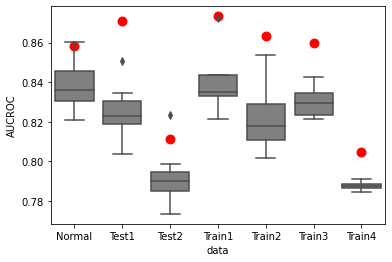

In [105]:
plt.figure(figsize=(6,4))
sns.boxplot(data=viz_df,x='data',y='AUCROC',color='grey')
plt.xticks([0,1,2,3,4,5,6], ['Normal','Test1','Test2','Train1','Train2','Train3','Train4'])
plt.scatter([0,1,2,3,4,5,6], [0.8584, 0.8711, 0.8111, 0.8733, 0.8633, 0.8599, 0.8048], c='r', s=80)
plt.show()

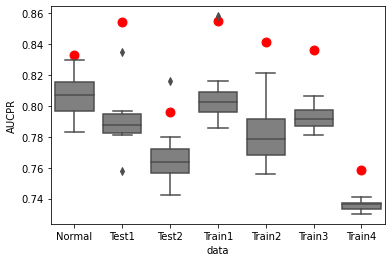

In [104]:
plt.figure(figsize=(6,4))
sns.boxplot(data=viz_df,x='data',y='AUCPR',color='grey')
plt.xticks([0,1,2,3,4,5,6], ['Normal','Test1','Test2','Train1','Train2','Train3','Train4'])
plt.scatter([0,1,2,3,4,5,6], [0.8332, 0.8545, 0.7958, 0.8549, 0.8414, 0.8363, 0.7585], c='r', s=80)
plt.show()

# Benchmark

In [14]:
cols = ['trainer_name', 'sampling_term','sampling_ratio','initial_epoch']
for result in os.listdir(tabular_result_path):
    data = pd.read_csv(tabular_result_path + result)
    print(result)
    print(data.groupby(cols)[['roc_auc','pr_auc']].agg(['mean']))

result_abalone9-18.csv
                                                        roc_auc  pr_auc
                                                           mean    mean
trainer_name sampling_term sampling_ratio initial_epoch                
BaseTrainer  0             0.00           0              0.8104  0.6478
NewTrainer   1             0.01           5              0.8223  0.6683
                                          20             0.8061  0.6455
                           0.10           5              0.8313  0.6679
                                          20             0.8086  0.6259
             5             0.01           5              0.7990  0.6292
                                          20             0.8168  0.6646
                           0.10           5              0.8146  0.6408
                                          20             0.8223  0.6540
result_shuttle-c0-vs-c4.csv
                                                        roc_auc pr_auc
              

In [71]:
os.listdir('./tabular_data/')

['abalone9-18.csv',
 'shuttle-c0-vs-c4.csv',
 'vowel0.csv',
 'wine.csv',
 'yeast-1-2-8-9_vs_7.csv',
 'yeast4.csv',
 'yeast5.csv',
 'yeast6.csv']

In [74]:
viz_df2 = pd.DataFrame(columns=['AUCROC','AUCPR','data'])
cols = ['trainer_name', 'sampling_term','sampling_ratio','initial_epoch']
for result in os.listdir(tabular_result_path):
    data = pd.read_csv(tabular_result_path + result)
    data = data.loc[data['trainer_name'] == 'NewTrainer']
    tmp = data.groupby(cols)[['roc_auc','pr_auc']].agg(['mean'])
    for roc, pr in zip(tmp['roc_auc'].values, tmp['pr_auc'].values):
        viz_df2 = viz_df2.append({
            'AUCROC': roc[0],
            'AUCPR': pr[0],
            'data': result
        }, ignore_index=True)

In [88]:
get_ensemble_result(ensemble_PATH= './0410_ensemble_sim_1/', data_path='./tabular_data/', name=os.listdir('./tabular_data/')[5], n_models=8)

<ipython-input-40-15a8bf3e8838>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["label"] = y_test


,mean,median,max,min
roc_auc,0.642681,0.640219,0.634656,0.670588
pr_auc,0.253252,0.245725,0.251499,0.280948


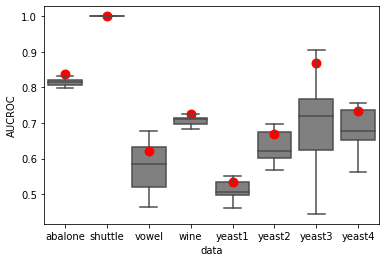

In [102]:
plt.figure(figsize=(6,4))
sns.boxplot(data=viz_df2,x='data',y='AUCROC',color='grey')
plt.xticks([0,1,2,3,4,5,6,7], ['abalone', 'shuttle', 'vowel', 'wine', 'yeast1', 'yeast2', 'yeast3', 'yeast4'])
plt.scatter([0,1,2,3,4,5,6,7], [0.8379, 1, 0.6212, 0.7259, 0.5336, 0.6706, 0.8690, 0.7332], c='r', s=80)
plt.show()

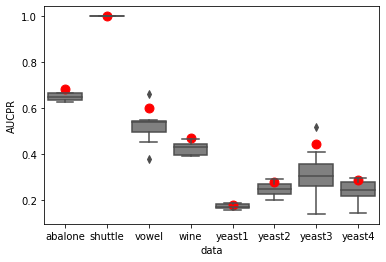

In [103]:
plt.figure(figsize=(6,4))
sns.boxplot(data=viz_df2,x='data',y='AUCPR',color='grey')
plt.xticks([0,1,2,3,4,5,6,7],['abalone', 'shuttle', 'vowel', 'wine', 'yeast1', 'yeast2', 'yeast3', 'yeast4'])
plt.scatter([0,1,2,3,4,5,6,7], [0.6820, 1, 0.6005, 0.4702, 0.1803, 0.2809, 0.4452, 0.2898], c='r', s=80)
plt.show()